---
title: "Regression with XGBoost"
format:
  html:
    code-fold: true
jupyter: python3
author: "kakamana"
date: "2023-01-21"
categories: [python, datacamp, regression, machine learning, XGBoost ]
image: "regressionXGBoost.jpg"

---

# Regression with XGBoost

After a brief review of supervised regression, you'll apply XGBoost to the regression task of predicting house prices in Ames, Iowa. Aside from learning how XGboost can evaluate the quality of your regression models, you will also learn about the two types of base learners it can use as weak learners.

This **Regression with XGBoost** is part of [Datacamp course: Extreme Gradient Boosting with XGBoost](https://app.datacamp.com/learn/courses/extreme-gradient-boosting-with-xgboost)

This is my learning experience of data science through DataCamp

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

plt.rcParams['figure.figsize'] = (7, 7)

## Regression review
- Common regression metrics
    - Root Mean Squared Error (RMSE)
    ![](Images/computing rmse.jpg)
    - Mean Absolute Erro (MAE)
    ![](Images/computing mae.jpg)

## Objective (loss) functions and base learners
- Objective functions and Why we use them
    - Quantifies how far off a prediction is from the actual result
    - Measures the difference between estimated and true values for some collection of data
    - Goal: Find the model that yields the minimum value of the loss function
- Common loss functions and XGBoost
    - Loss function names in xgboost:
        - reg:linear - use for regression problems
        - reg:logistic - use for classification problems when you want just decision, not probability
        - binary:logistic - use when you want probability rather than just decision
- Base learners and why we need them
    - XGBoost involves creating a meta-model that is composed of many individual models that combine to give a final prediction
    - Individual models = base learners
    - Want base learners that when combined create final prediction that is **non-linear**
    - Each base learner should be good at distinguishing or predicting different parts of the dataset
    - Two kinds of base learners: tree and linear

### Decision trees as base learners
It's now time to build an XGBoost model to predict house prices - not in Boston, Massachusetts, as you saw in the video, but in Ames, Iowa! This dataset of housing prices has been pre-loaded into a DataFrame called df. If you explore it in the Shell, you'll see that there are a variety of features about the house and its location in the city.

In this exercise, your goal is to use trees as base learners. By default, XGBoost uses trees as base learners, so you don't have to specify that you want to use trees here with `booster="gbtree"`.

> Note: `reg:linear` is replaced with `reg:squarederror`

In [2]:
df = pd.read_csv('dataset/ames_housing_trimmed_processed.csv')
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MSSubClass            1460 non-null   int64  
 1   LotFrontage           1460 non-null   float64
 2   LotArea               1460 non-null   int64  
 3   OverallQual           1460 non-null   int64  
 4   OverallCond           1460 non-null   int64  
 5   YearBuilt             1460 non-null   int64  
 6   Remodeled             1460 non-null   int64  
 7   GrLivArea             1460 non-null   int64  
 8   BsmtFullBath          1460 non-null   int64  
 9   BsmtHalfBath          1460 non-null   int64  
 10  FullBath              1460 non-null   int64  
 11  HalfBath              1460 non-null   int64  
 12  BedroomAbvGr          1460 non-null   int64  
 13  Fireplaces            1460 non-null   int64  
 14  GarageArea            1460 non-null   int64  
 15  MSZoning_FV          

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiatethe XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=123, n_estimators=10)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
print("Next, you'll train an XGBoost model using linear base learners and XGBoost's learning API. Will it perform better or worse?")

RMSE: 28106.463641
Next, you'll train an XGBoost model using linear base learners and XGBoost's learning API. Will it perform better or worse?


### Linear base learners
Now that you've used trees as base models in XGBoost, let's use the other kind of base model that can be used with XGBoost - a linear learner. This model, although not as commonly used in XGBoost, allows you to create a regularized linear regression using XGBoost's powerful learning API. However, because it's uncommon, you have to use XGBoost's own non-scikit-learn compatible functions to build the model, such as `xgb.train()`.

In order to do this you must create the parameter dictionary that describes the kind of booster you want to use (similarly to how you created the dictionary in Chapter 1 when you used `xgb.cv()`). The key-value pair that defines the booster type (base model) you need is `"booster":"gblinear"`.

Once you've created the model, you can use the `.train()` and `.predict()` methods of the model just like you've done in the past.

In [5]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test = xgb.DMatrix(data=X_test, label=y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror"}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
print("\nit looks like linear base learners performed better!")

RMSE: 44305.046080

it looks like linear base learners performed better!


### Evaluating model quality
It's now time to begin evaluating model quality.

Here, you will compare the RMSE and MAE of a cross-validated XGBoost model on the Ames housing data.

In [6]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-valdiation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4,
                    num_boost_round=5, metrics='rmse', as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results['test-rmse-mean']).tail(1))

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0    141767.533478      429.451090   142980.434934    1193.795492
1    102832.547530      322.472076   104891.395389    1223.157368
2     75872.617039      266.474211    79478.938743    1601.345019
3     57245.651780      273.624239    62411.921348    2220.150063
4     44401.298519      316.423620    51348.279619    2963.378136
4    51348.279619
Name: test-rmse-mean, dtype: float64


In [7]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-valdiation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4,
                    num_boost_round=5, metrics='mae', as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results['test-mae-mean']).tail(1))

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0   127343.480012     668.306786  127633.999275   2404.005913
1    89770.056424     456.963854   90122.501070   2107.909841
2    63580.789280     263.405054   64278.558741   1887.567534
3    45633.156501     151.883868   46819.168555   1459.818435
4    33587.090044      86.998100   35670.647207   1140.607311
4    35670.647207
Name: test-mae-mean, dtype: float64


## Regularization and base learners in XGBoost
- Regularization in XGBoost
    - Regularization is a control on model complexity
    - Want models that are both accurate and as simple as possible
    - Regularization parameters in XGBoost:
        - Gamma - minimum loss reduction allowed for a split to occur
        - alpha - L1 regularization on leaf weights, larger values mean more regularization
        - lambda - L2 regularization on leaf weights
- Base learners in XGBoost
    - Linear Base learner
        - Sum of linear terms
        - Boosted model is weighted sum of linear models (thus is itself linear)
        - Rarely used
    - Tree Base learner
        - Decision tree
        - Boosted model is weighted sum of decision trees (nonlinear)
        - Almost exclusively used in XGBoost

### Using regularization in XGBoost
Having seen an example of l1 regularization in the video, you'll now vary the l2 regularization penalty - also known as `"lambda"` - and see its effect on overall model performance on the Ames housing dataset.

In [8]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror", "max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:
    # Update l2 strength
    params['lambda'] = reg

    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2,
                            num_boost_round=5, metrics='rmse', as_pandas=True, seed=123)

    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse['test-rmse-mean'].tail(1).values[0])

# Loot at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))
print("\nIt looks like as as the value of 'lambda' increases, so does the RMSE.")

Best rmse as a function of l2:
    l2          rmse
0    1  52275.357003
1   10  57746.063828
2  100  76624.627811

It looks like as as the value of 'lambda' increases, so does the RMSE.


### Visualizing individual XGBoost trees
Now that you've used XGBoost to both build and evaluate regression as well as classification models, you should get a handle on how to visually explore your models. Here, you will visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset.

XGBoost has a `plot_tree()` function that makes this type of visualization easy. Once you train a model using the XGBoost learning API, you can pass it to the `plot_tree()` function along with the number of trees you want to plot using the `num_trees` argument.

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

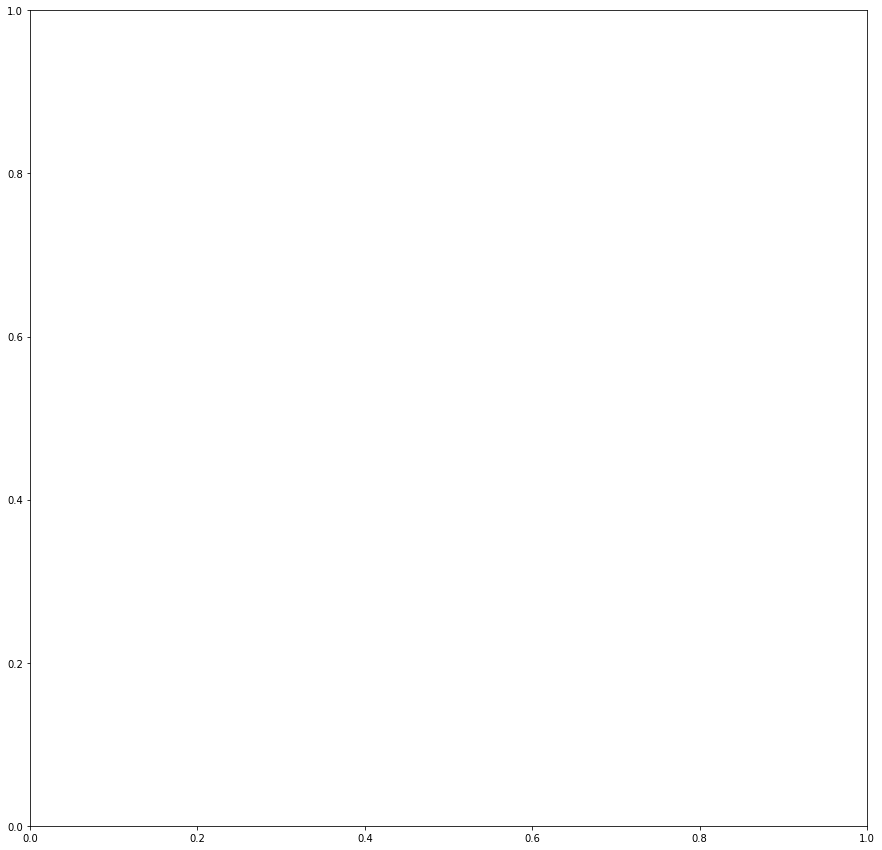

In [12]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameters dictionary: params
params = {"objective":'reg:squarederror', 'max_depth':2}

# Train the model: xg_reg
xg_reg = xgb.train(dtrain=housing_dmatrix, params=params, num_boost_round=10)

# Plot the first tree
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(xg_reg, num_trees=0, ax=ax);

# Plot the fifth tree
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(xg_reg, num_trees=4, ax=ax);

# Plot the last tree sideways
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(xg_reg, rankdir="LR", num_trees=9, ax=ax);
print("\nHave a look at each of the plots. They provide insight into how the model arrived at its final decisions and what splits it made to arrive at those decisions. This allows us to identify which features are the most important in determining house price. In the next exercise, you'll learn another way of visualizing feature importances.")

### Visualizing feature importances: What features are most important in my dataset
Another way to visualize your XGBoost models is to examine the importance of each feature column in the original dataset within the model.

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a `plot_importance()` function that allows you to do exactly this, and you'll get a chance to use it in this exercise!

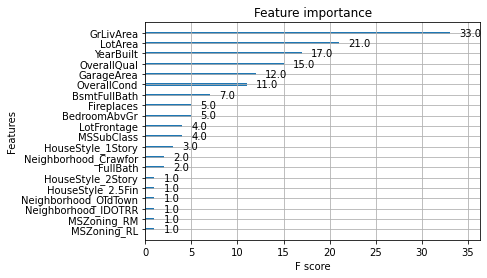

In [13]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(dtrain=housing_dmatrix, params=params, num_boost_round=10)

# Plot the feature importance
xgb.plot_importance(xg_reg);